In [99]:
# script that analyzes and computes figures for experimental data on SNRPB and GIGYF1
import db_utils
import AF_plot_functions
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import leastsq
from matplotlib import gridspec
import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
%matplotlib inline

from matplotlib.ticker import FormatStrFormatter

connect = db_utils.get_connection()
cursor = connect.cursor()

path = '/Users/luck/IMB/projects/AlphaFold/exp_data_analysis/'

In [100]:
def get_saturation_curve_data_GIGYF(project_id,NL_id,mCit_id,connect,FL_id):
    titration_query = f"""select a.project_id,a.NL_plasmid,a.mCit_plasmid,a.NL_property,a.mCit_property,
                c.measurement/d.measurement BRET,a.NL_plasmid_id,a.mCit_plasmid_id,a.plate_id,b.avg_FL,
                e.measurement totLu 
                from luthy_data.plate_layout a, luthy_data.FL_avg_points b, luthy_data.LU_raw c, 
                    luthy_data.LU_raw d, luthy_data.LU_raw e 
                where a.project_id='{project_id}' and a.include=1 and a.project_id=b.project_id and 
                    a.project_id=c.project_id and a.project_id=d.project_id and a.project_id=e.project_id and 
                    a.plate_id=b.plate_id and a.plate_id=c.plate_id and a.plate_id=d.plate_id and 
                    a.plate_id=e.plate_id and a.well_id=b.well_id and a.well_id=c.well_id and 
                    a.well_id=d.well_id and a.well_id=e.well_id and a.NL_plasmid_id='{NL_id}' and 
                    a.mCit_plasmid_id='{mCit_id}' and c.measurement_id='accLu01' and d.measurement_id='donLu01' 
                    and e.measurement_id='totLu01' and b.measurement_id='{FL_id}'"""
    bleedthrough_query = f"""select c.measurement/d.measurement bleedthrough,a.plate_id
                from luthy_data.plate_layout a, luthy_data.LU_raw c, luthy_data.LU_raw d
                where a.project_id='{project_id}' and a.include=1 and a.project_id=c.project_id and 
                    a.project_id=d.project_id and a.plate_id=c.plate_id and a.plate_id=d.plate_id and 
                    a.well_id=c.well_id and a.well_id=d.well_id and a.NL_plasmid_id='KL_03' and 
                    a.mCit_plasmid_id='empty' and c.measurement_id='accLu01' and d.measurement_id='donLu01'"""
    bkg_query = f"""select b.avg_FL bkg_FL,c.measurement bkg_LU,a.plate_id
                    from luthy_data.plate_layout a, luthy_data.FL_avg_points b, luthy_data.LU_raw c 
                    where a.project_id='{project_id}' and a.include=1 and a.project_id=b.project_id and 
                        a.project_id=c.project_id and a.plate_id=b.plate_id and a.plate_id=c.plate_id and 
                        a.well_id=b.well_id and a.well_id=c.well_id and a.NL_plasmid_id='KL_01' and 
                        a.mCit_plasmid_id='empty' and b.measurement_id='{FL_id}' and c.measurement_id='totLu01'"""

    BRET_df = pandas.read_sql(titration_query,connect)
    BT_df = pandas.read_sql(bleedthrough_query,connect)
#    print(BT_df)
    bkg_df = pandas.read_sql(bkg_query,connect)

    FLref = {'Lu126r01':100,'Lu128r01':100,'Lu129r01':94,'Lu132r01':100,'Lu133r01':100}
    gain = {100:44576,94:28842}
    
    BRET_df['normFL'] = (BRET_df['avg_FL'] - gain[FLref[project_id]])/gain[FLref[project_id]]
    bkg_df['normFL'] = (bkg_df['bkg_FL'] - gain[FLref[project_id]])/gain[FLref[project_id]]
#    print(bkg_df)
    
    BRET_df['norm_BRET'] = BRET_df['BRET'] - np.mean(list(BT_df['bleedthrough']))
    BRET_df['expr_ratio'] = (BRET_df['normFL'] - np.mean(list(bkg_df['normFL'])))/(BRET_df['totLu'] - np.mean(list(bkg_df['bkg_LU'])))
#    print(BRET_df)
    
    return BRET_df



('KL_477', 'KL_612', 'Lu128r01', 'FL01')
('KL_477', 'KL_825', 'Lu128r01', 'FL01')
('KL_477', 'KL_612', 'Lu129r01', 'FL02')
('KL_477', 'KL_825', 'Lu129r01', 'FL02')
('KL_477', 'KL_612', 'Lu126r01', 'FL01')
('KL_792', 'KL_612', 'Lu126r01', 'FL01')


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,conn

/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2780009097.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'bret50':bret50,
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/

('KL_791', 'KL_612', 'Lu126r01', 'FL01')
('KL_790', 'KL_612', 'Lu126r01', 'FL01')
('KL_477', 'KL_612', 'Lu129r01', 'FL02')


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,conn

('KL_792', 'KL_612', 'Lu129r01', 'FL02')
('KL_791', 'KL_612', 'Lu129r01', 'FL02')
('KL_790', 'KL_612', 'Lu129r01', 'FL02')


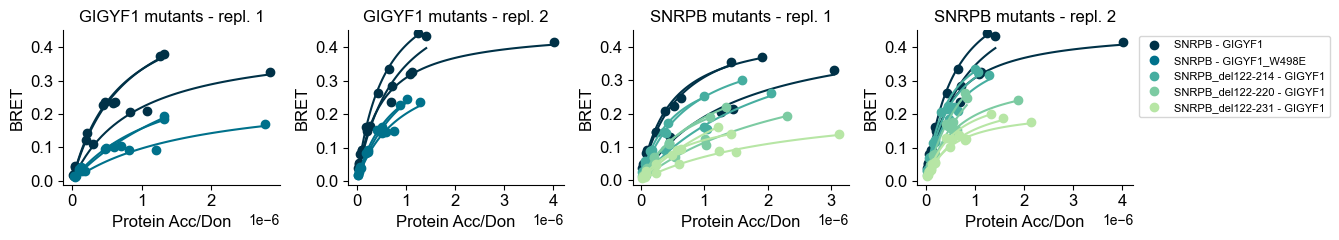

In [101]:
# plot titration curves, fit the data and compute BRET 50
plasmid_pair_sets = [
    [('KL_477','KL_612','Lu128r01','FL01'),('KL_477','KL_825','Lu128r01','FL01')],
    [('KL_477','KL_612','Lu129r01','FL02'),('KL_477','KL_825','Lu129r01','FL02')],
#     [('KL_477','KL_612','Lu132r01','FL01'),('KL_477','KL_833','Lu132r01','FL01')],
#     [('KL_477','KL_612','Lu133r01','FL01'),('KL_477','KL_833','Lu133r01','FL01')],
    [('KL_477','KL_612','Lu126r01','FL01'),('KL_792','KL_612','Lu126r01','FL01'),
     ('KL_791','KL_612','Lu126r01','FL01'),('KL_790','KL_612','Lu126r01','FL01')],
    [('KL_477','KL_612','Lu129r01','FL02'),('KL_792','KL_612','Lu129r01','FL02'),               
     ('KL_791','KL_612','Lu129r01','FL02'),('KL_790','KL_612','Lu129r01','FL02')]
                    ]

labels_colors = {('KL_477','KL_612'):('SNRPB - GIGYF1','#003147'),
          ('KL_477','KL_833'):('SNRPB - GIGYF1_L508F','#045275'),
          ('KL_477','KL_825'):('SNRPB - GIGYF1_W498E','#00718B'),
          ('KL_792','KL_612'):('SNRPB_del122-214 - GIGYF1','#46AEA0'),
          ('KL_791','KL_612'):('SNRPB_del122-220 - GIGYF1','#7CCBA2'),
          ('KL_790','KL_612'):('SNRPB_del122-231 - GIGYF1','#B7E6A5')}

titles = ['GIGYF1 mutants - repl. 1','GIGYF1 mutants - repl. 2','SNRPB mutants - repl. 1','SNRPB mutants - repl. 2']

# create dict where data is safed
fit_dict = {}

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'normFL':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(13.5,2.5))

artist_collection = []
labels_collection = []

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,4,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data_GIGYF(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'bret50':bret50,
                                          'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.title(titles[p],fontsize=12)
    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=0.45)
#    plt.xlim(right=0.13)
    ax = plt.gca()
#    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    if p in [0,2]:
        handles, labels = ax.get_legend_handles_labels()
        artist_collection = artist_collection + handles
        labels_collection = labels_collection + labels

artist_collection_final = []
labels_collection_final = []

for i in [0,3,9,12,15]:
    artist_collection_final.append(artist_collection[i])
    labels_collection_final.append(labels_collection[i])

plt.legend(handles=artist_collection_final,labels=labels_collection_final,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'SNRPB_GIGYF1_titration_indiv_Lu126r01_Lu128r01_Lu129r01_Lu132r01_Lu133r01.pdf')
plt.savefig(path+'SNRPB_GIGYF1_titration_indiv_Lu126r01_Lu128r01_Lu129r01_Lu132r01_Lu133r01.jpeg',dpi=300)
plt.show()

In [102]:
bret50_df

,pair,project_id,bret50,bret50_err,bretmax,bretmax_err,color,NL_plasmid_id,mCit_plasmid_id
0,SNRPB - GIGYF1,Lu128r01,9.145833e-07,1.571479e-07,0.420628,0.029796,#003147,KL_477,KL_612
1,SNRPB - GIGYF1,Lu128r01,7.818992e-07,1.789471e-07,0.593420,0.068929,#003147,KL_477,KL_612
2,SNRPB - GIGYF1,Lu128r01,6.959439e-07,1.564478e-07,0.564835,0.063090,#003147,KL_477,KL_612
3,SNRPB - GIGYF1_W498E,Lu128r01,1.793279e-06,6.714357e-07,0.270495,0.052508,#00718B,KL_477,KL_825
4,SNRPB - GIGYF1_W498E,Lu128r01,2.350929e-06,1.279467e-06,0.524547,0.202271,#00718B,KL_477,KL_825
5,SNRPB - GIGYF1_W498E,Lu128r01,1.372585e-06,4.805212e-07,0.371245,0.079528,#00718B,KL_477,KL_825
6,SNRPB - GIGYF1,Lu129r01,5.700076e-07,8.680099e-08,0.636374,0.044351,#003147,KL_477,KL_612
7,SNRPB - GIGYF1,Lu129r01,4.802223e-07,8.901756e-08,0.456290,0.027247,#003147,KL_477,KL_612
8,SNRPB - GIGYF1,Lu129r01,8.006969e-07,3.328643e-07,0.621946,0.119755,#003147,KL_477,KL_612
9,SNRPB - GIGYF1_W498E,Lu129r01,7.557494e-07,2.334328e-07,0.414083,0.073067,#00718B,KL_477,KL_825


In [103]:
bret_expr_df

,project_id,NL_plasmid,mCit_plasmid,NL_property,mCit_property,BRET,NL_plasmid_id,mCit_plasmid_id,plate_id,avg_FL,totLu,normFL,norm_BRET,expr_ratio
0,Lu128r01,pcDNA3.1 NL-SNRPB,pcDNA3.1 mCit-His3C-GIGYF1,2ng,12.5ng,0.3033,KL_477,KL_612,1.0,772.5,508177.0,-0.982670,0.014233,2.212791e-08
1,Lu128r01,pcDNA3.1 NL-SNRPB,pcDNA3.1 mCit-His3C-GIGYF1,2ng,25ng,0.3277,KL_477,KL_612,1.0,1618.5,454871.0,-0.963691,0.038633,6.667152e-08
2,Lu128r01,pcDNA3.1 NL-SNRPB,pcDNA3.1 mCit-His3C-GIGYF1,2ng,50ng,0.3996,KL_477,KL_612,1.0,6038.5,439742.0,-0.864535,0.110533,2.956599e-07
3,Lu128r01,pcDNA3.1 NL-SNRPB,pcDNA3.1 mCit-His3C-GIGYF1,2ng,100ng,0.4936,KL_477,KL_612,1.0,12190.8,324529.0,-0.726517,0.204533,8.297252e-07
4,Lu128r01,pcDNA3.1 NL-SNRPB,pcDNA3.1 mCit-His3C-GIGYF1,1ng,100ng,0.4983,KL_477,KL_612,1.0,14857.8,306543.0,-0.666686,0.209233,1.075444e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,Lu129r01,pcDNA3.1 cmyc-NL-SNRPB_del122-231,pcDNA3.1 mCit-His3C-GIGYF1,2ng,25ng,0.3280,KL_790,KL_612,3.0,3645.5,1011217.0,-0.873604,0.037617,1.104223e-07
208,Lu129r01,pcDNA3.1 cmyc-NL-SNRPB_del122-231,pcDNA3.1 mCit-His3C-GIGYF1,2ng,50ng,0.3466,KL_790,KL_612,3.0,5639.0,968977.0,-0.804487,0.056217,1.873719e-07
209,Lu129r01,pcDNA3.1 cmyc-NL-SNRPB_del122-231,pcDNA3.1 mCit-His3C-GIGYF1,2ng,100ng,0.4275,KL_790,KL_612,3.0,19695.2,1010371.0,-0.317135,0.137117,6.668563e-07
210,Lu129r01,pcDNA3.1 cmyc-NL-SNRPB_del122-231,pcDNA3.1 mCit-His3C-GIGYF1,1ng,100ng,0.4140,KL_790,KL_612,3.0,16497.5,707092.0,-0.428004,0.123617,7.979611e-07


('KL_477', 'KL_612', 'Lu128r01', 'FL01')
   project_id         NL_plasmid                mCit_plasmid NL_property  \
2    Lu128r01  pcDNA3.1 NL-SNRPB  pcDNA3.1 mCit-His3C-GIGYF1         2ng   
8    Lu128r01  pcDNA3.1 NL-SNRPB  pcDNA3.1 mCit-His3C-GIGYF1         2ng   
14   Lu128r01  pcDNA3.1 NL-SNRPB  pcDNA3.1 mCit-His3C-GIGYF1         2ng   

   mCit_property    BRET NL_plasmid_id mCit_plasmid_id  plate_id  avg_FL  \
2           50ng  0.3996        KL_477          KL_612       1.0  6038.5   
8           50ng  0.4125        KL_477          KL_612       2.0  6374.8   
14          50ng  0.4323        KL_477          KL_612       3.0  7283.0   

       totLu    normFL  norm_BRET    expr_ratio  
2   439742.0 -0.864535   0.110533  2.956599e-07  
8   710604.0 -0.856990   0.123433  1.932457e-07  
14  737368.0 -0.836616   0.143233  2.139275e-07  
('KL_477', 'KL_825', 'Lu128r01', 'FL01')
   project_id         NL_plasmid                      mCit_plasmid  \
20   Lu128r01  pcDNA3.1 NL-SNRPB  pcDN

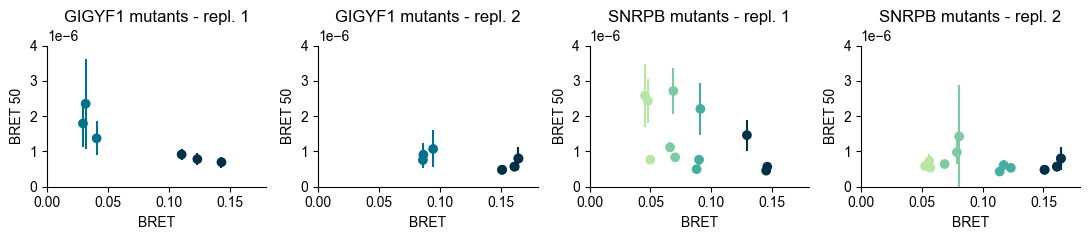

In [105]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(11,2.5))

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,4,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]),'norm_BRET'])
        print(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2])])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'color'])


    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.title(titles[p],fontsize=12)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
    plt.ylim((0,4*10**-6))
    plt.xlim((0,0.18))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'SNRPB_GIGYF1_BRET50err_vs_BRET_Lu126r01_Lu128r01_Lu129r01_Lu132r01_Lu133r01.pdf')
plt.savefig(path+'SNRPB_GIGYF1_BRET50err_vs_BRET_Lu126r01_Lu128r01_Lu129r01_Lu132r01_Lu133r01.jpeg',dpi=300)
plt.show()

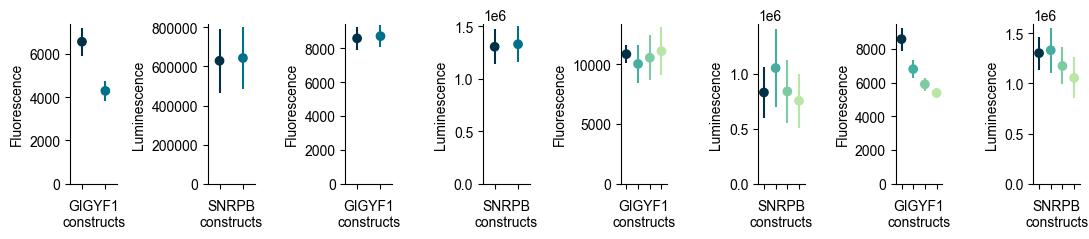

In [107]:
plt.figure(figsize=(11,2.5))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,8,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('GIGYF1\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(1,8,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('SNRPB\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'SNRPB_GYGIF1_expr_Lu126r01_Lu128r01_Lu129r01_Lu132r01_Lu133r01.pdf')
plt.savefig(path+'SNRPB_GYGIF1_expr_Lu126r01_Lu128r01_Lu129r01_Lu132r01_Lu133r01.jpeg',dpi=300)
plt.show()

('KL_477', 'KL_612', 'Lu132r01', 'FL01')
('KL_477', 'KL_833', 'Lu132r01', 'FL01')
('KL_477', 'KL_612', 'Lu133r01', 'FL01')
('KL_477', 'KL_833', 'Lu133r01', 'FL01')


/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_82379/2951354035.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,conn

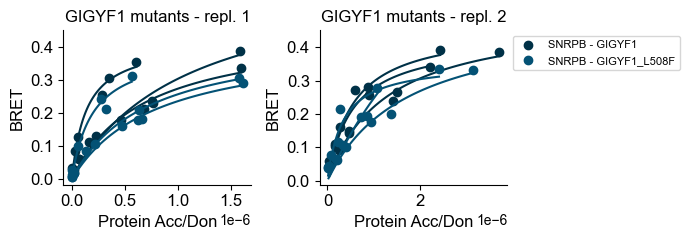

In [108]:
# plot titration curves, fit the data and compute BRET 50
plasmid_pair_sets = [
    [('KL_477','KL_612','Lu132r01','FL01'),('KL_477','KL_833','Lu132r01','FL01')],
    [('KL_477','KL_612','Lu133r01','FL01'),('KL_477','KL_833','Lu133r01','FL01')],
                    ]

labels_colors = {('KL_477','KL_612'):('SNRPB - GIGYF1','#003147'),
          ('KL_477','KL_833'):('SNRPB - GIGYF1_L508F','#045275'),
          ('KL_477','KL_825'):('SNRPB - GIGYF1_W498E','#00718B'),
          ('KL_792','KL_612'):('SNRPB_del122-214 - GIGYF1','#46AEA0'),
          ('KL_791','KL_612'):('SNRPB_del122-220 - GIGYF1','#7CCBA2'),
          ('KL_790','KL_612'):('SNRPB_del122-231 - GIGYF1','#B7E6A5')}

titles = ['GIGYF1 mutants - repl. 1','GIGYF1 mutants - repl. 2']

# create dict where data is safed
fit_dict = {}

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'normFL':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(7,2.5))

artist_collection = []
labels_collection = []

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data_GIGYF(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'bret50':bret50,
                                          'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.title(titles[p],fontsize=12)
    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=0.45)
#    plt.xlim(right=0.13)
    ax = plt.gca()
#    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    if p == 0:
        handles, labels = ax.get_legend_handles_labels()
        artist_collection = artist_collection + handles
        labels_collection = labels_collection + labels

artist_collection_final = []
labels_collection_final = []

for i in [0,3]:
    artist_collection_final.append(artist_collection[i])
    labels_collection_final.append(labels_collection[i])


plt.legend(handles=artist_collection_final,labels=labels_collection_final,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'SNRPB_GIGYF1_L508F_titration_indiv_Lu132r01_Lu133r01.pdf')
plt.savefig(path+'SNRPB_GIGYF1_L508F_titration_indiv_Lu132r01_Lu133r01.jpeg',dpi=300)
plt.show()

('KL_477', 'KL_612', 'Lu132r01', 'FL01')
   project_id         NL_plasmid                mCit_plasmid NL_property  \
2    Lu132r01  pcDNA3.1 NL-SNRPB  pcDNA3.1 mCit-His3C-GIGYF1         2ng   
8    Lu132r01  pcDNA3.1 NL-SNRPB  pcDNA3.1 mCit-His3C-GIGYF1         2ng   
14   Lu132r01  pcDNA3.1 NL-SNRPB  pcDNA3.1 mCit-His3C-GIGYF1         2ng   

   mCit_property    BRET NL_plasmid_id mCit_plasmid_id  plate_id   avg_FL  \
2           50ng  0.4233        KL_477          KL_612       1.0  11696.2   
8           50ng  0.4040        KL_477          KL_612       2.0   7881.5   
14          50ng  0.4196        KL_477          KL_612       3.0   5844.0   

        totLu    normFL  norm_BRET    expr_ratio  
2   1116453.0 -0.737612   0.130717  2.311836e-07  
8   1057639.0 -0.823190   0.111417  1.623933e-07  
14  2076390.0 -0.868898   0.127017  6.014942e-08  
('KL_477', 'KL_833', 'Lu132r01', 'FL01')
   project_id         NL_plasmid                      mCit_plasmid  \
20   Lu132r01  pcDNA3.1 NL-SNR

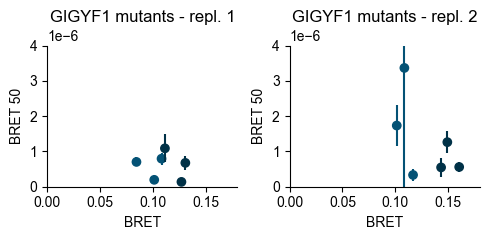

In [111]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(5,2.5))

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]),'norm_BRET'])
        print(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2])])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]),'color'])


    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.title(titles[p],fontsize=12)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
    plt.ylim((0,4*10**-6))
    plt.xlim((0,0.18))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'SNRPB_GIGYF1_L508F_BRET50err_vs_BRET_Lu132r01_Lu133r01.pdf')
plt.savefig(path+'SNRPB_GIGYF1_L508F_BRET50err_vs_BRET_Lu132r01_Lu133r01.jpeg',dpi=300)
plt.show()

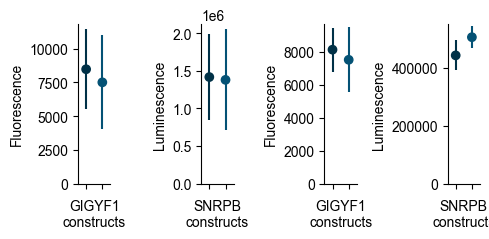

In [110]:
plt.figure(figsize=(5,2.5))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,4,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('GIGYF1\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(1,4,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('SNRPB\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'SNRPB_GYGIF1_L508F_expr_Lu132r01_Lu133r01.pdf')
plt.savefig(path+'SNRPB_GYGIF1_L508F_expr_Lu132r01_Lu133r01.jpeg',dpi=300)
plt.show()